# COGS 108 - EDA Checkpoint

# Names

- Cassandra Henrickson
- Daniel Han
- Ezra Lu
- Jasmine Qiang
- Wing Leung (Calvin)

<a id='research_question'></a>
# Research Question

How is the severity of the traffic jam due to a car crash impacted as a result of where the accident occurs and different weather conditions?

# Setup

In [1]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(style="white", font_scale=2)

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# make sure pandas, numpy, and statistics are imported
import pandas as pd
import numpy as np
import statistics

import warnings
warnings.filterwarnings('ignore')

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'


In [2]:
df = pd.read_csv('US_Accidents_Dec20.csv')

In [3]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
print('Total observations: ', len(df))

Total observations:  4232541


# Data Cleaning

1.1 - Seeing the columns and number of accidents we are working with

In [5]:
#49 different variables
df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [6]:
# San Diego has 29416 accidents
san_diego = df[df['City'] == 'San Diego']
accident_sandiego = san_diego['City'].count()
accident_sandiego

29416

1.2 - Slicing the dataframe to only include the columns and variables of interest

In [7]:
#slicing df to only include columns we need - Severity, City, Weather Condition, Junction, Stop, and Traffic Signal
df = df.loc[:, ['Severity', 'City', 'Weather_Condition', 'Junction', 'Stop', 'Traffic_Signal']]

#slicing to only get car accidents that happened in San Diego
df = df.loc[df['City'] == 'San Diego']

1.3 - Combining "Light Rain" and "Rain" weather data and "Overcast" and "Cloudy" data together 

We decided to combine the "Light Rain" with the "Rain" Data because there are not many cases of heavy rain in San Diego and both light and heavy rain lead to driving hazards. Similarly, we grouped "Cloudy" data with "Overcast" data because they are very similar weather types and San Diego usually does not have full cloud coverage. 

In [8]:
#Combine 'Fair' to 'Clear'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Fair'], 'Clear')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Scattered Clouds'], 'Clear')

#Combine 'Light Rain' & 'Heavy Rain' to 'Rain'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Light Rain'], 'Rain')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Heavy Rain'], 'Rain')

#Combine 'Overcast' & 'Mostly Cloudy' to 'Cloudy'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Overcast'], 'Cloudy')
df['Weather_Condition'] = df['Weather_Condition'].replace(['Mostly Cloudy'], 'Cloudy')

#Combined 'Haze' to 'Fog'
df['Weather_Condition'] = df['Weather_Condition'].replace(['Haze'], 'Fog')

1.4a - Grouping traffic accidents that took place elsewhere on the road in a separate column 

In [9]:
#group all other traffic accidents that occurred elsewhere on the road into a column "other place"
#if 'other place' = 'True', accident took place other than at a Junction, Stop, or Traffic Signal

df['equal_or_lower_than_3?'] = df[df==False].count(axis=1)
df['Other place'] = df['equal_or_lower_than_3?'].apply(lambda x: 'True' if x == 3 else 'False')

#set order of column names
df = df[['Severity', 'City', 'Weather_Condition', 'Junction', 'Stop', 'Traffic_Signal', 'equal_or_lower_than_3?','Other place']]


df.head(7)

,Severity,City,Weather_Condition,Junction,Stop,Traffic_Signal,equal_or_lower_than_3?,Other place
42886,3,San Diego,Clear,False,False,False,3,True
42887,3,San Diego,Cloudy,False,False,False,3,True
42905,2,San Diego,Cloudy,False,False,False,3,True
42909,3,San Diego,Cloudy,False,False,False,3,True
42951,3,San Diego,Cloudy,True,False,False,2,False
42952,2,San Diego,Cloudy,False,False,False,3,True
42980,2,San Diego,Clear,False,False,False,3,True


1.4b - See how many accidents took place somewhere other than at a Junction, Stop Sign, or Traffic Signal

In [10]:
#24672 accidents took place elsewhere on the road; 4744 accidents took place at a Junction, Stop, or Traffic Signal
df['Other place'].value_counts()

True     24672
False     4744
Name: Other place, dtype: int64

1.5a - Look at the number different weather conditions in San Diego

In [11]:
#all of the weather conditions in San Diego
df['Weather_Condition'].unique()

array(['Clear', 'Cloudy', 'Partly Cloudy', 'Fog', 'Mist', 'Rain', nan,
       'Drizzle', 'Light Drizzle', 'Partly Cloudy / Windy', 'Smoke',
       'Light Snow', 'T-Storm', 'Thunder in the Vicinity',
       'Patches of Fog', 'Heavy T-Storm', 'Thunderstorms and Rain',
       'Heavy Thunderstorms and Rain', 'Volcanic Ash', 'Shallow Fog',
       'Mostly Cloudy / Windy', 'Rain / Windy', 'Light Rain with Thunder',
       'N/A Precipitation', 'Fair / Windy', 'Heavy Rain / Windy',
       'Light Thunderstorms and Rain'], dtype=object)

In [12]:
#original number of weather conditions
df['Weather_Condition'].value_counts()

Clear                           13033
Cloudy                           9249
Partly Cloudy                    4074
Rain                             2064
Fog                               735
Light Drizzle                      25
Mist                               12
Thunder in the Vicinity            11
Light Snow                          9
Mostly Cloudy / Windy               6
Smoke                               5
Light Rain with Thunder             5
Shallow Fog                         4
Drizzle                             3
Heavy T-Storm                       2
Rain / Windy                        2
T-Storm                             2
Fair / Windy                        2
Thunderstorms and Rain              2
N/A Precipitation                   2
Partly Cloudy / Windy               1
Heavy Thunderstorms and Rain        1
Volcanic Ash                        1
Heavy Rain / Windy                  1
Light Thunderstorms and Rain        1
Patches of Fog                      1
Name: Weathe

1.5b - Only include specific weather conditions in our dataframe and look at their values

In [13]:
#slicing df to only include car accident observations with certain weather conditions
#reset index
df = df.loc[(df['Weather_Condition'] =='Rain') \
            | (df['Weather_Condition'] == 'Fog') \
            | (df['Weather_Condition'] == 'Cloudy') \
            | (df['Weather_Condition'] == 'Clear')].reset_index()

In [14]:
#final number of weather conditions and number of accidents per condition
df['Weather_Condition'].value_counts()

Clear     13033
Cloudy     9249
Rain       2064
Fog         735
Name: Weather_Condition, dtype: int64

1.6 - Check for missing data and total accidents in our cleaned dataframe. Show final, cleaned dataframe

In [15]:
#check for missing data                                                              
print(df['Severity'].hasnans)
print(df['City'].hasnans)
print(df['Weather_Condition'].hasnans)
print(df['Junction'].hasnans)
print(df['Stop'].hasnans)
print(df['Traffic_Signal'].hasnans)

False
False
False
False
False
False


In [16]:
#number of accidents now, with cleaned data
#print total number of accidents with cleaned data set
print(df['City'].count())

25081


In [17]:
#drop index column and calculation column 'equal_or_lower_than_3?' that determined if accident took place elsewhere
df = df.drop(columns = ['index', 'equal_or_lower_than_3?'])

#show cleaned car accident dataset
df.head(10)

,Severity,City,Weather_Condition,Junction,Stop,Traffic_Signal,Other place
0,3,San Diego,Clear,False,False,False,True
1,3,San Diego,Cloudy,False,False,False,True
2,2,San Diego,Cloudy,False,False,False,True
3,3,San Diego,Cloudy,False,False,False,True
4,3,San Diego,Cloudy,True,False,False,False
5,2,San Diego,Cloudy,False,False,False,True
6,2,San Diego,Clear,False,False,False,True
7,3,San Diego,Cloudy,False,False,False,True
8,2,San Diego,Cloudy,False,False,False,True
9,3,San Diego,Cloudy,False,False,False,True


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

1.1 - Severity of Traffic due to different weather conditions (Rain, Overcast, Clear, Fog)

Text(0, 0.5, 'Number of Accidents')

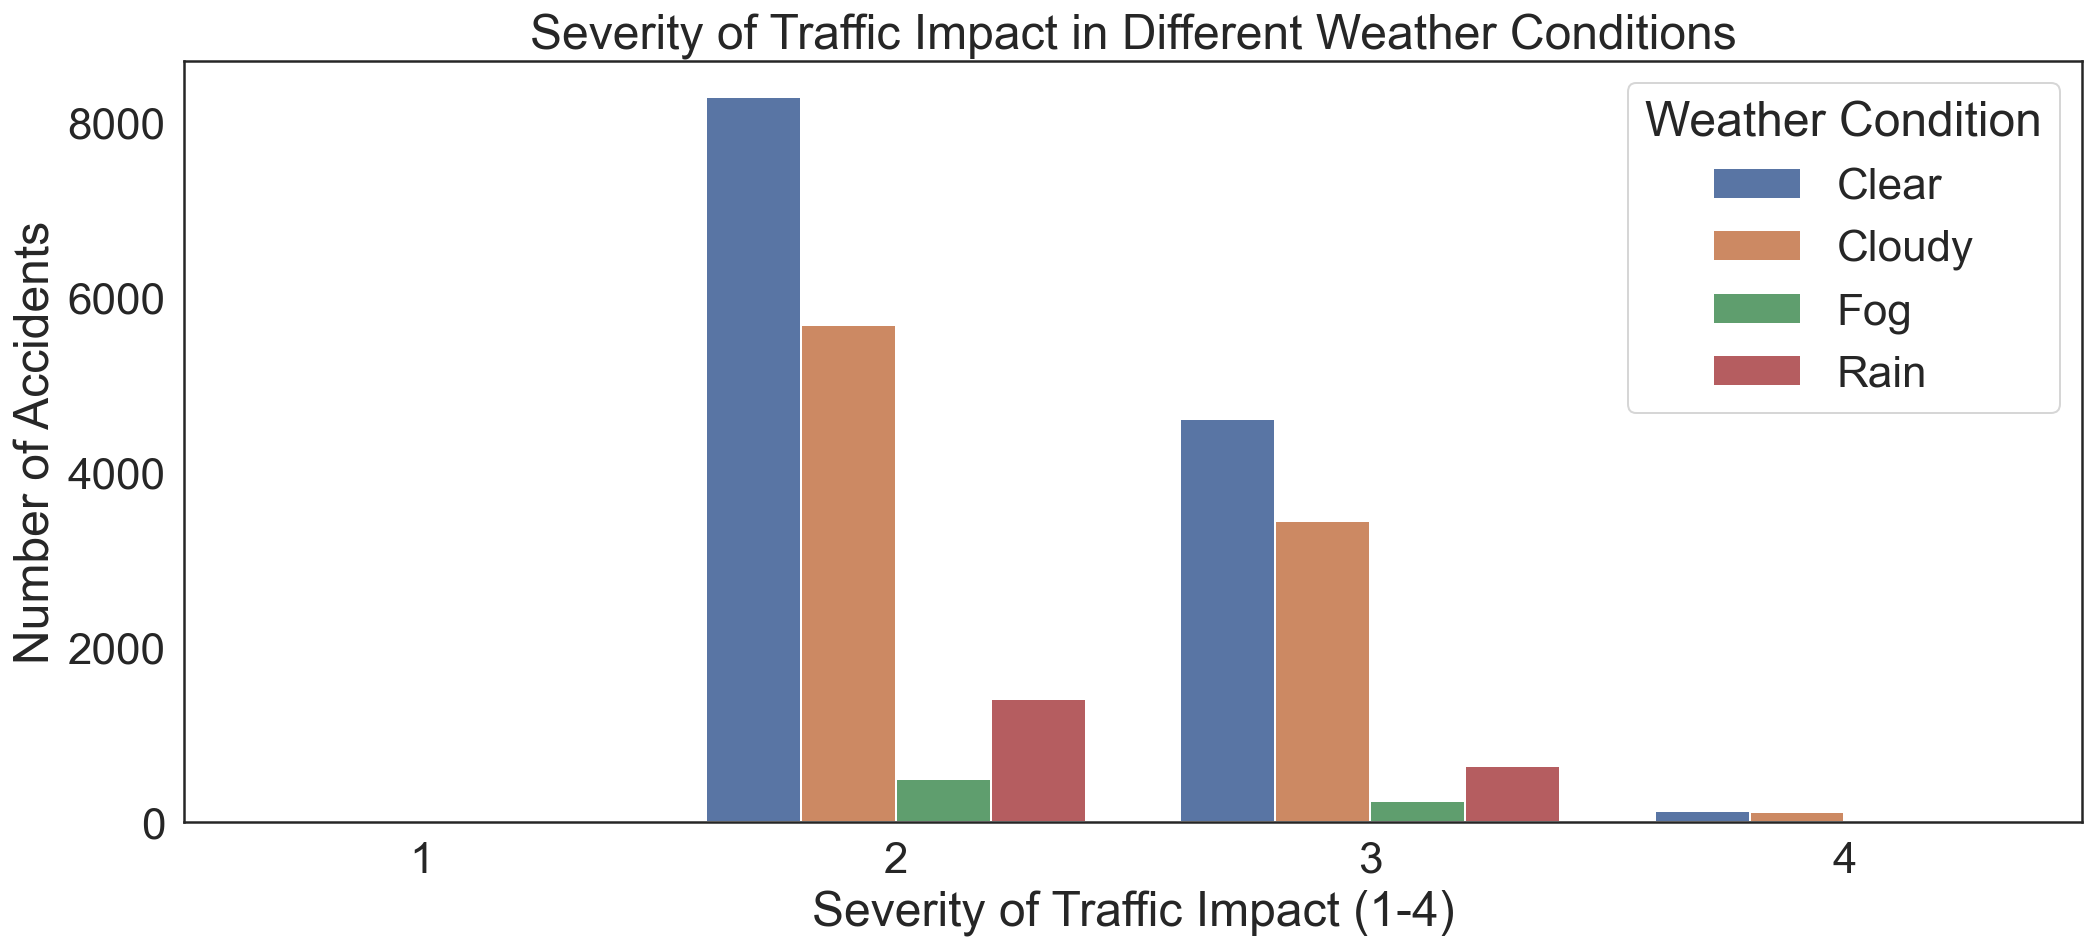

In [18]:
#show the severity of traffic impact in different weather conditions
severity_weather_condition = sns.countplot(data = df, x = 'Severity', hue = 'Weather_Condition')

#setting axis and legend titles
plt.legend(title='Weather Condition')
severity_weather_condition.set_title('Severity of Traffic Impact in Different Weather Conditions')
severity_weather_condition.set_xlabel('Severity of Traffic Impact (1-4)')
severity_weather_condition.set_ylabel('Number of Accidents')

Explanation/Interpretation of graph
- so maybe more people are driving in overcast and clear weather -- thus more accidents...
- make sure we didn't lose weather data 
- hypothesis test

In [19]:
#hypothesis test

explanation/interpretation of test

1.2 - Severity of Traffic Impact due to different road locations

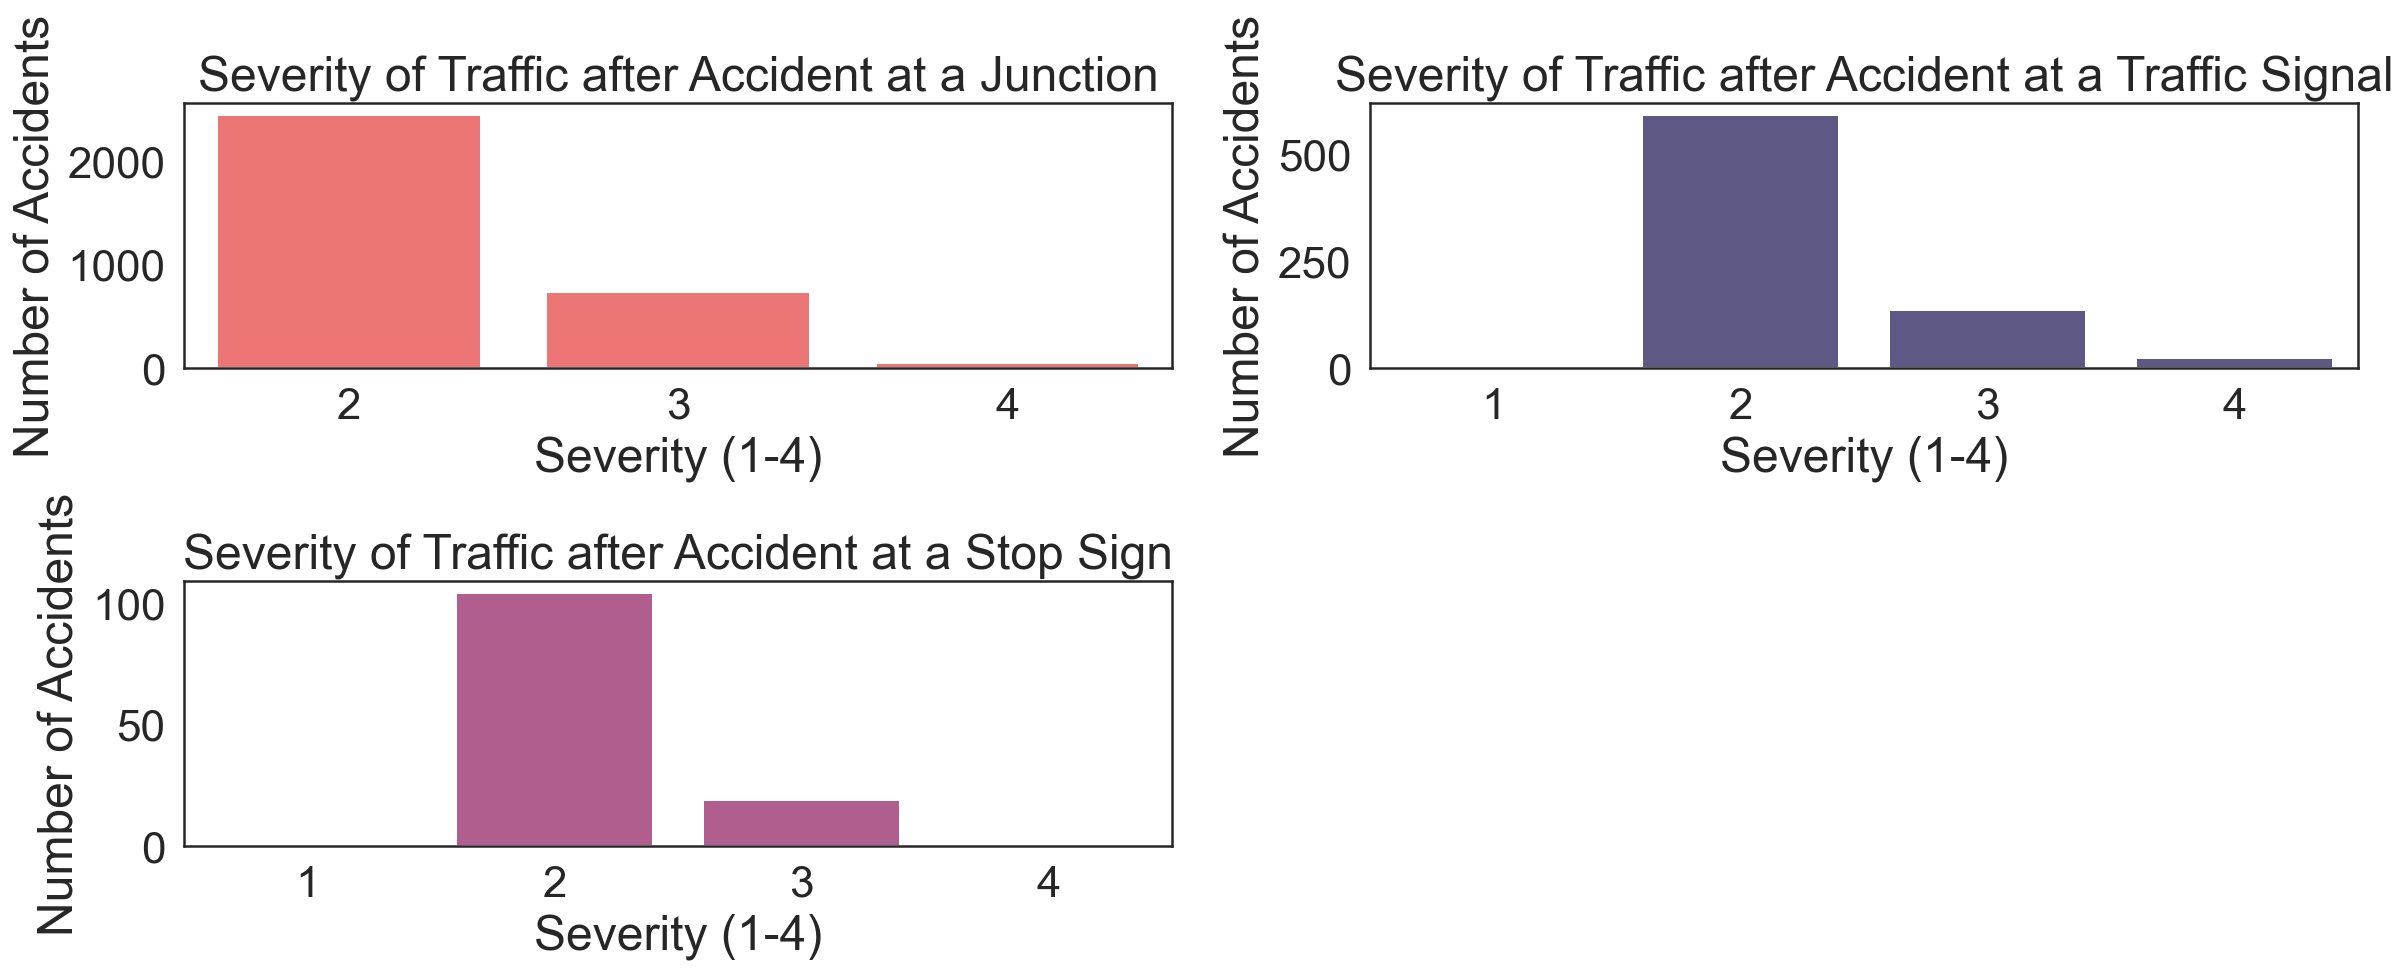

In [20]:
#severity of traffic impact due to different road locations - countplots

#severity of traffic at junction
plt.subplot(2, 2, 1)  
junction = sns.countplot(df[df['Junction'] == True ]['Severity'], color = '#ff6361')

#set axis titles
junction.set_title('Severity of Traffic after Accident at a Junction')
junction.set_xlabel('Severity (1-4)')
junction.set_ylabel('Number of Accidents')

#severity of traffic at traffic signal
plt.subplot(2, 2, 2)
traffic_signal = sns.countplot(df[df['Traffic_Signal'] == True ]['Severity'], color = '#58508d')

#set axis titles
traffic_signal.set_title('Severity of Traffic after Accident at a Traffic Signal')
traffic_signal.set_xlabel('Severity (1-4)')
traffic_signal.set_ylabel('Number of Accidents')

#severity of traffic at stop sign
plt.subplot(2, 2, 3)  
stop = sns.countplot(df[df['Stop'] == True ]['Severity'], color = '#bc5090')

#set axis titles
stop.set_title('Severity of Traffic after Accident at a Stop Sign')
stop.set_xlabel('Severity (1-4)')
stop.set_ylabel('Number of Accidents')

#set scale...?
plt.tight_layout()

Interpretation/Explanation of graph

In [21]:
#hypothesis test

Interpretation/Explanation of test results

1.3 - Severity of Traffic due to the interaction between weather condition and road location of accident

In [22]:
#heat map of the mean severity and number of accidents based on weather and location
#maybe have two side by side (one mean, one number)

heatmap_df = pd.DataFrame(df, columns = ['Weather_Condition', 'Junction', 'Stop', 'Traffic_Signal', 'Other place'])
heatmap_df
#severity_mean = df['Severity'].mean()

confusion_matrix = pd.crosstab(df['Weather_Condition'], df['Junction'], rownames=['Weather Condition'], colnames=['Junction'])
print (confusion_matrix)


Junction           False  True 
Weather Condition              
Clear              11364   1669
Cloudy              8069   1180
Fog                  623    112
Rain                1794    270


- print out number of accidents per variable to check data

weather vs accident place grid - mean severity and # of accidents
- on grid, would have a heat map (red = mean of severity high; vibrant/transparency = if number of accidents was high) - ordered pairs
    (2.6, 1500)
    - two legends, one for color gradient (severity) and one for transparency (eg grayscale) (# accidents)
    - or can have two diff graphs, one for severity and one for # accidents

break up explanations as much as possible. introduce topic and then explain results
hypothesis test to accompnay first and second visualizations, 3rd visualization is something we will explore in proper analysis
- 1.1 - severity in terms of weather
    - hypothesis test: looking just at rain against clear bc its weird there are so few traffic accidents
        null: traffic accidents are 20% more likely to happen in rain than clear weather (look at internet)
        H1: clear distributions are higher than rain distributions 
        - do they crash less in the rain enough to make you reject the null that rain crashes are more likely than clear 
- 1.2 - severity in terms of location
- 1.3 - interaction